<a href="https://colab.research.google.com/github/kaitlynrv/classification-predictions/blob/main/OrganicsCustomers_KaitlynVickers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [303]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

#Define Functions

In [304]:
# function to calculate perofrmance from sklearn logistic regression models
def performance_rpt(model, X_test, y_test):
    # Calculate performance metrics using the provided model
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    y_true = y_test
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    aucroc = roc_auc_score(y_test, y_proba)

    # Print the performance metrics
    #print(" -- Model Performance on Test Set --")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"AUC-ROC  : {aucroc:.4f}\n")

    return accuracy, precision, recall, aucroc

In [305]:
# function for model coefficents
def rpt_model_variables(model):
    # Get the intercept term
    intercept = model.intercept_

    # Access the coefficients (weights) of the model, i rounded them
    coefficients = np.round(model.coef_[0],decimals=4)

    # Create DataFrames for intercept and coefficients
    #df_intercept = pd.DataFrame({'feature': ['Intercept'], 'coefficient': [intercept[0]]})
    df_coefficients = pd.DataFrame({'feature': X3.columns, 'coefficient': coefficients})
    df_coefficients['abs_coefficient'] = df_coefficients['coefficient'].abs()
    df_coefficients.sort_values(by='abs_coefficient', ascending=False, inplace=True)

    # if you want to add intercept to table
    #df_model = pd.concat([df_intercept, df_coefficients]).reset_index(drop=True)

    # Print the DataFrame
    print(df_coefficients)

    return df_coefficients

In [306]:
# plot variable importance
def plot_variable_imp(df_coef):
  df_plt = df_coef[df_coef['abs_coefficient'] != 0]
  reject_vars = df_coef[df_coef['abs_coefficient'] == 0]['feature'].tolist()

  plt.figure(figsize=(5, 10))
  plt.title('Variable Importance')
  plt.xlabel('Coefficient')
  plt.ylabel('Feature')
  sns.barplot(data=df_plt,
                     y=df_plt['feature'],
                     x=df_plt['abs_coefficient'], color="lightblue")

  plt.show()
  print("-- rejected --")
  for i in reject_vars:
    print(f" {i}")

#Load and Explore Data

In [307]:
# load the data into a pandas dataframe
df = pd.read_csv('/content/organics-1.csv')
dfnew = pd.read_csv('/content/New_organics-1.csv')

In [308]:
#visualize organics

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               22223 non-null  int64  
 1   DemAffl          21138 non-null  float64
 2   DemAge           20715 non-null  float64
 3   DemCluster       21549 non-null  float64
 4   DemClusterGroup  21549 non-null  object 
 5   DemGender        19711 non-null  object 
 6   DemReg           21758 non-null  object 
 7   DemTVReg         21758 non-null  object 
 8   PromClass        22223 non-null  object 
 9   PromSpend        22223 non-null  float64
 10  PromTime         21942 non-null  float64
 11  TargetBuy        22223 non-null  int64  
 12  TargetAmt        22223 non-null  int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 2.2+ MB
None


,ID,DemAffl,DemAge,DemCluster,DemClusterGroup,DemGender,DemReg,DemTVReg,PromClass,PromSpend,PromTime,TargetBuy,TargetAmt
0,140,10.0,76.0,16.0,C,U,Midlands,Wales & West,Gold,16000.00,4.0,0,0
1,620,4.0,49.0,35.0,D,U,Midlands,Wales & West,Gold,6000.00,5.0,0,0
2,868,5.0,70.0,27.0,D,F,Midlands,Wales & West,Silver,0.02,8.0,1,1
3,1120,10.0,65.0,51.0,F,M,Midlands,Midlands,Tin,0.01,7.0,1,1
4,2313,11.0,68.0,4.0,A,F,Midlands,Midlands,Tin,0.01,8.0,0,0


In [309]:
#visualize new organics

print(dfnew.info())
dfnew.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               150 non-null    int64  
 1   DemAffl          150 non-null    int64  
 2   DemAge           150 non-null    int64  
 3   DemCluster       150 non-null    int64  
 4   DemClusterGroup  150 non-null    object 
 5   DemGender        150 non-null    object 
 6   DemReg           150 non-null    object 
 7   DemTVReg         150 non-null    object 
 8   PromClass        150 non-null    object 
 9   PromSpend        150 non-null    float64
 10  PromTime         150 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 13.0+ KB
None


,ID,DemAffl,DemAge,DemCluster,DemClusterGroup,DemGender,DemReg,DemTVReg,PromClass,PromSpend,PromTime
0,1,6,46,27,D,F,South East,London,Tin,0.01,8
1,2,10,39,12,B,M,Midlands,Ulster,Tin,0.01,5
2,3,7,75,12,B,M,Midlands,East,Silver,4000.00,7
3,4,7,72,12,B,F,Midlands,Ulster,Silver,1250.00,23
4,5,7,43,53,F,M,North,N West,Tin,0.01,5


#Data Preprocessing and Dealing with Null Values

In [310]:
#find null values for organics and new organics

print(df.isnull().sum())
print(dfnew.isnull().sum())

ID                    0
DemAffl            1085
DemAge             1508
DemCluster          674
DemClusterGroup     674
DemGender          2512
DemReg              465
DemTVReg            465
PromClass             0
PromSpend             0
PromTime            281
TargetBuy             0
TargetAmt             0
dtype: int64
ID                 0
DemAffl            0
DemAge             0
DemCluster         0
DemClusterGroup    0
DemGender          0
DemReg             0
DemTVReg           0
PromClass          0
PromSpend          0
PromTime           0
dtype: int64


The only row with more than 20% missing values is the DemGender, however since there is already a defined "unknown" value in this column, we will replace all null values with the unknown statistic

In [311]:
#replace DemAffl with the most frequently occurring value
df['DemAffl'].fillna(df['DemAffl'].mode()[0], inplace=True)

In [312]:
#replace nulls in DemAge and PromTime with mean
df['DemAge'].fillna(df['DemAge'].mean(), inplace=True)
df['PromTime'].fillna(df['PromTime'].mean(), inplace=True)

In [313]:
#fill nulls in DemGender, DemReg, and DemTVReg with 'U' for unknown
columns_to_fill = ['DemGender', 'DemReg', 'DemTVReg']
df[columns_to_fill] = df[columns_to_fill].fillna('U')

In [314]:
#drop rows with null values in DemCluster (which will also drop all null rows for DemCluster Group)
df = df.dropna(subset=['DemCluster'])

In [315]:
#check for null values
print(df.isnull().sum())
print(df.info())

ID                 0
DemAffl            0
DemAge             0
DemCluster         0
DemClusterGroup    0
DemGender          0
DemReg             0
DemTVReg           0
PromClass          0
PromSpend          0
PromTime           0
TargetBuy          0
TargetAmt          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21549 entries, 0 to 22222
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               21549 non-null  int64  
 1   DemAffl          21549 non-null  float64
 2   DemAge           21549 non-null  float64
 3   DemCluster       21549 non-null  float64
 4   DemClusterGroup  21549 non-null  object 
 5   DemGender        21549 non-null  object 
 6   DemReg           21549 non-null  object 
 7   DemTVReg         21549 non-null  object 
 8   PromClass        21549 non-null  object 
 9   PromSpend        21549 non-null  float64
 10  PromTime         21549 non-null  float64
 11  Ta

Total rows is now 21549

In [316]:
# Convert targetbuy from an integer to a categorical variable
df['TargetBuy'] = df['TargetBuy'].astype('category')

In [317]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21549 entries, 0 to 22222
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ID               21549 non-null  int64   
 1   DemAffl          21549 non-null  float64 
 2   DemAge           21549 non-null  float64 
 3   DemCluster       21549 non-null  float64 
 4   DemClusterGroup  21549 non-null  object  
 5   DemGender        21549 non-null  object  
 6   DemReg           21549 non-null  object  
 7   DemTVReg         21549 non-null  object  
 8   PromClass        21549 non-null  object  
 9   PromSpend        21549 non-null  float64 
 10  PromTime         21549 non-null  float64 
 11  TargetBuy        21549 non-null  category
 12  TargetAmt        21549 non-null  int64   
dtypes: category(1), float64(5), int64(2), object(5)
memory usage: 2.2+ MB
None


,ID,DemAffl,DemAge,DemCluster,DemClusterGroup,DemGender,DemReg,DemTVReg,PromClass,PromSpend,PromTime,TargetBuy,TargetAmt
0,140,10.0,76.0,16.0,C,U,Midlands,Wales & West,Gold,16000.00,4.0,0,0
1,620,4.0,49.0,35.0,D,U,Midlands,Wales & West,Gold,6000.00,5.0,0,0
2,868,5.0,70.0,27.0,D,F,Midlands,Wales & West,Silver,0.02,8.0,1,1
3,1120,10.0,65.0,51.0,F,M,Midlands,Midlands,Tin,0.01,7.0,1,1
4,2313,11.0,68.0,4.0,A,F,Midlands,Midlands,Tin,0.01,8.0,0,0


#Exploratory Analysis

In [318]:
#Check the gender distribution
df['DemGender'].value_counts()

F    11752
M     5648
U     4149
Name: DemGender, dtype: int64

Note: There are almost twice as many Females as Males noted in this data set

In [319]:
#Check the PromClass distribution
df['PromClass'].value_counts()

Silver      8306
Tin         6281
Gold        6145
Platinum     817
Name: PromClass, dtype: int64

Note: Most individuals in this data set are in the Silver class

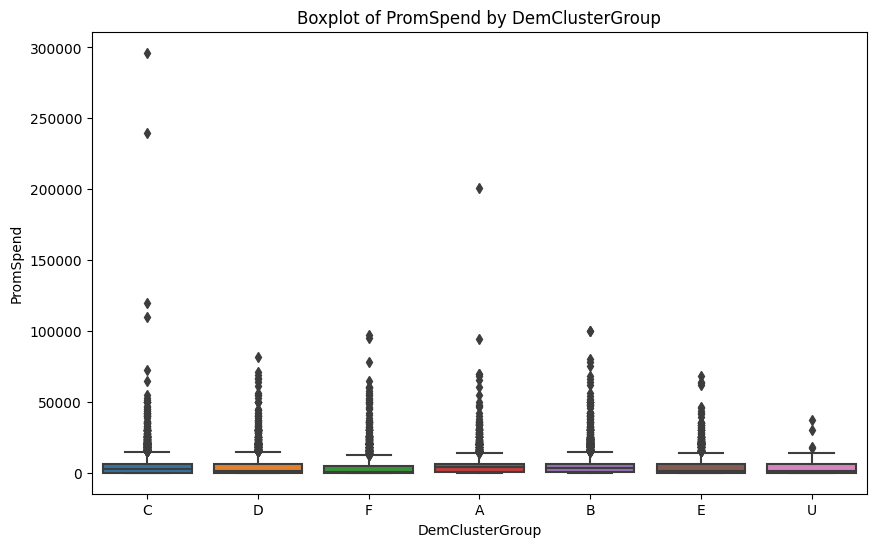

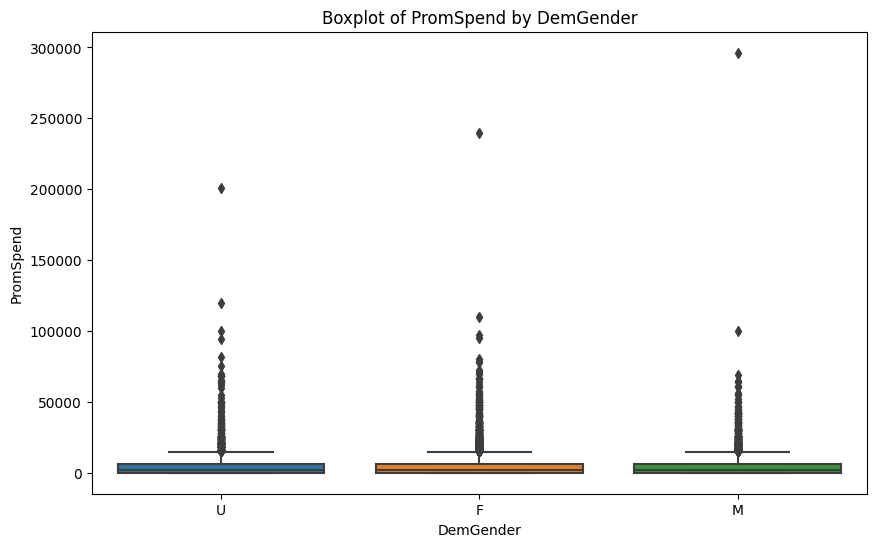

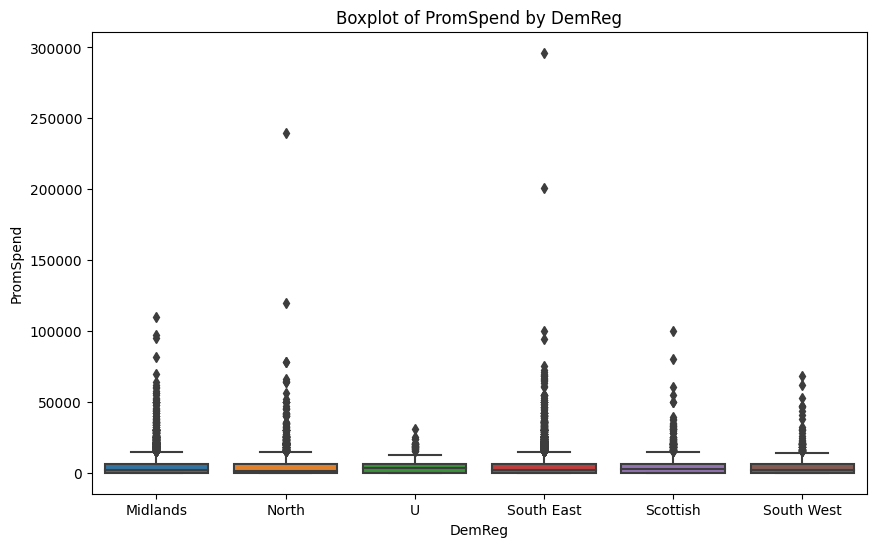

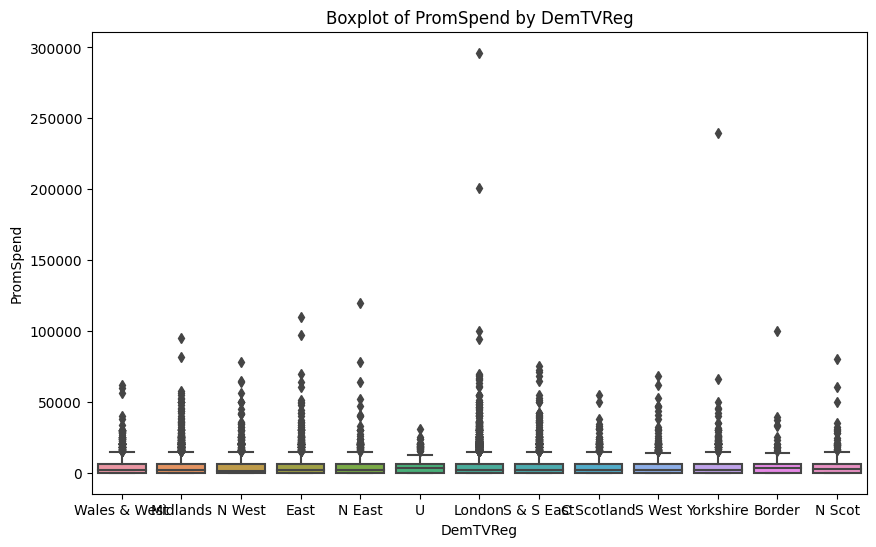

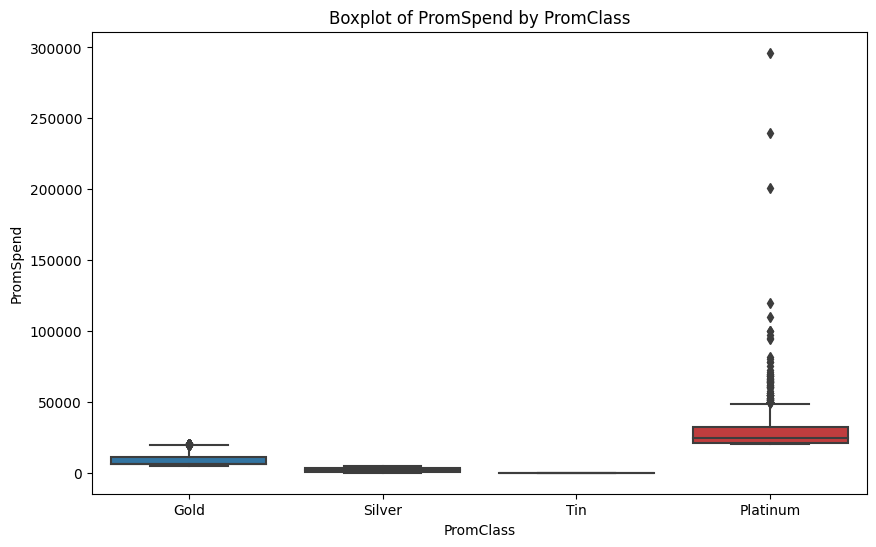

In [320]:
#Check boxplots of all PromSpend by categorical variables
cat_col = ['DemClusterGroup','DemGender','DemReg','DemTVReg','PromClass']

for col in cat_col:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='PromSpend', data=df)
    plt.title(f'Boxplot of PromSpend by {col}')
    plt.show()

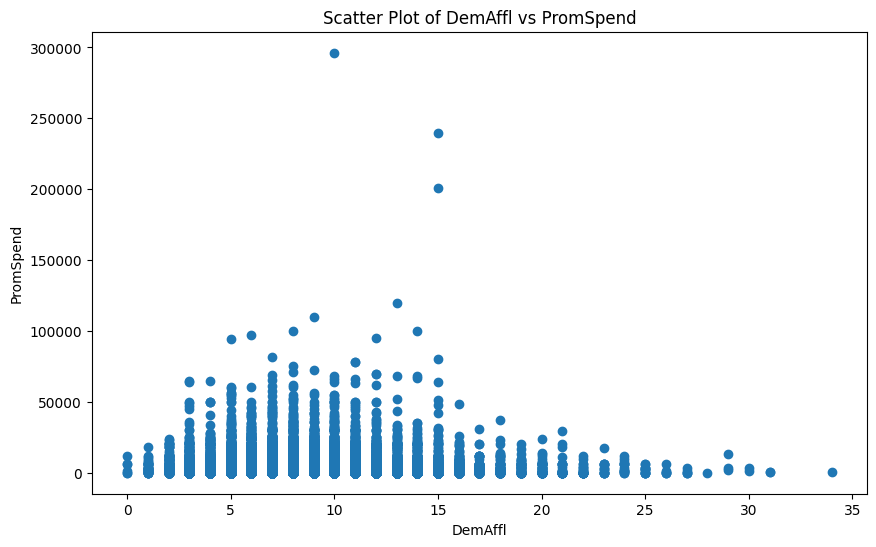

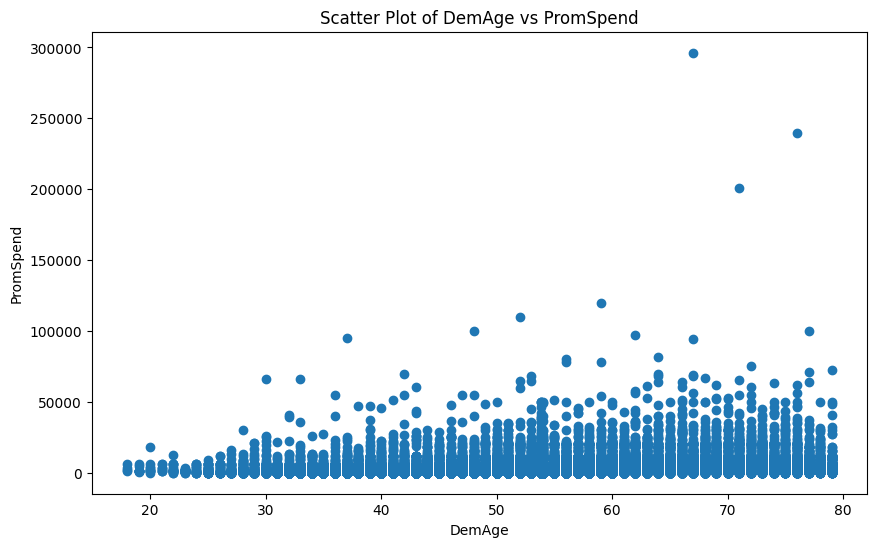

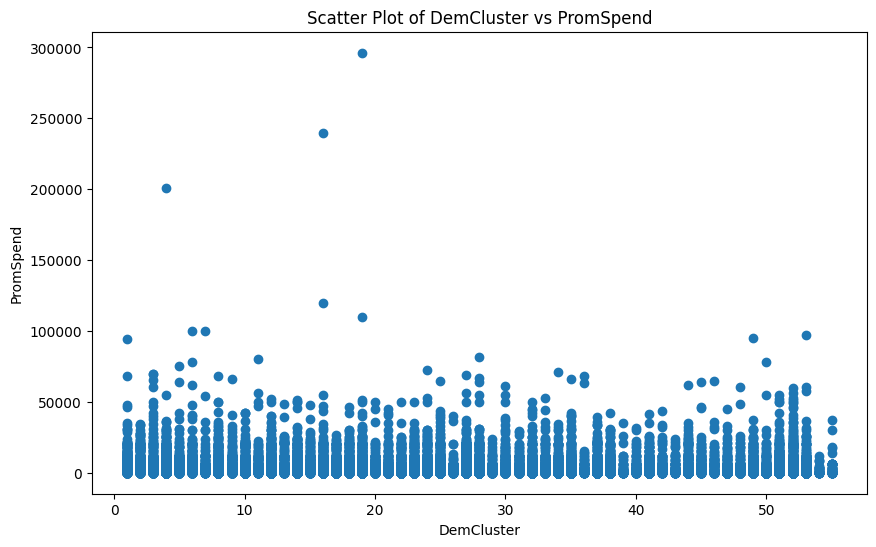

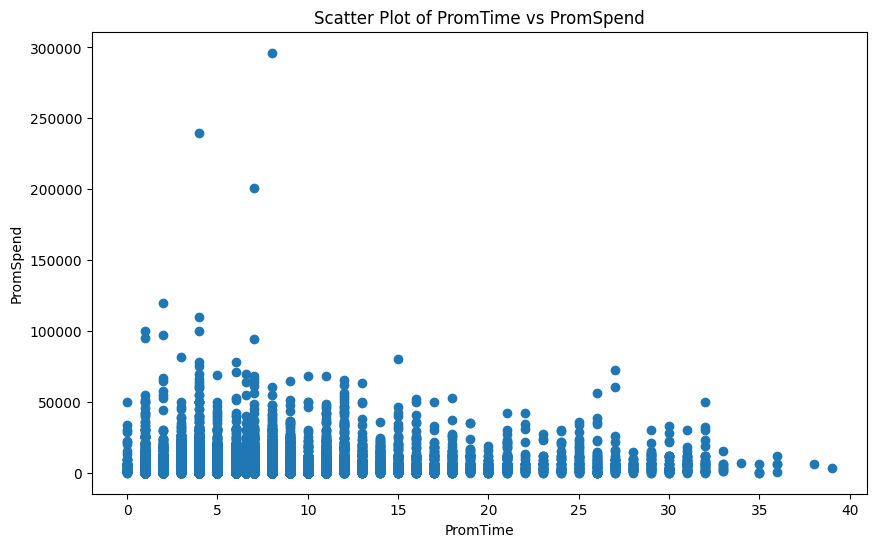

In [321]:
#create scatter plot for all numeric columns and PromSpend

num_col = ['DemAffl', 'DemAge', 'DemCluster', 'PromTime']

for col in num_col:
    plt.figure(figsize=(10, 6))
    plt.scatter(df[col], df['PromSpend'])
    plt.title(f'Scatter Plot of {col} vs PromSpend')
    plt.xlabel(col)
    plt.ylabel('PromSpend')
    plt.show()

Notes:
*   Those with an Affluence Grade from 7-15 tend to spend more
*   As age increases, so does spending
*   DemCluster does not appear to be very correlated with spending
*   As the time as a loyalty member increases, spending seems to decrease





#Modeling the Data
For the following, we will have six different models to predict the a TargetBuy column for our NewOrganics data set:


*   Full Regression
*   Reduced logistic regression model using sklearn with L1 regularization
*   Reduced logistic regression model using sklearn with L2 regularization
*   Reduced logistic regression model using sklearn with Elastic Net regularization
*   A Decision Tree Model
*   A Random Forest Model









##Model 1: Full Logistic Regression

In [322]:
#define categorical columns
cat_col = ['DemClusterGroup','DemGender','DemReg','DemTVReg','PromClass']

#don't consider TargetAmt since NewOrganics data set does not have this column
X = df.drop(['TargetBuy','ID','TargetAmt'], axis=1)
#Create dummy variables for nominal inputs
X = pd.get_dummies(X, columns=cat_col, drop_first=False)

y = df['TargetBuy']
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15084 entries, 4476 to 16280
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DemAffl                15084 non-null  float64
 1   DemAge                 15084 non-null  float64
 2   DemCluster             15084 non-null  float64
 3   PromSpend              15084 non-null  float64
 4   PromTime               15084 non-null  float64
 5   DemClusterGroup_A      15084 non-null  uint8  
 6   DemClusterGroup_B      15084 non-null  uint8  
 7   DemClusterGroup_C      15084 non-null  uint8  
 8   DemClusterGroup_D      15084 non-null  uint8  
 9   DemClusterGroup_E      15084 non-null  uint8  
 10  DemClusterGroup_F      15084 non-null  uint8  
 11  DemClusterGroup_U      15084 non-null  uint8  
 12  DemGender_F            15084 non-null  uint8  
 13  DemGender_M            15084 non-null  uint8  
 14  DemGender_U            15084 non-null  uint8  
 15 

In [323]:
#Fit full logistic regression model to examine the significance of the terms
X = X_train
X = sm.add_constant(X)
y=y_train

logit_full = sm.Logit(y, X).fit()

#Print summary
print(logit_full.summary())

Optimization terminated successfully.
         Current function value: 0.432203
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              TargetBuy   No. Observations:                15084
Model:                          Logit   Df Residuals:                    15055
Method:                           MLE   Df Model:                           28
Date:                Wed, 22 Nov 2023   Pseudo R-squ.:                  0.2250
Time:                        04:23:03   Log-Likelihood:                -6519.3
converged:                       True   LL-Null:                       -8412.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.5289   1.36e+06  -3.88e-07      1.000   -2.67e+06    2.67e

In [324]:
# Generate predicted values for training set
pprob = logit_full.predict(X)

# Create predicted category for success using 50% cutoff
psuccess = (pprob > 0.5).astype(int)

# Add new variables to the training data set
X_train['p_success'] = psuccess
X_train['p_prob'] = pprob
X_train['y'] = y_train

X_train.info()


# Generate predicted values for test set

X_test = sm.add_constant(X_test)

pprob_test = logit_full.predict(X_test)

# Create predicted category for success using 50% cutoff
psuccess_test = (pprob_test > 0.5).astype(int)

# Add new variables to the response data set
X_test['p_success'] = psuccess_test
X_test['p_prob'] = pprob_test

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15084 entries, 4476 to 16280
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   DemAffl                15084 non-null  float64 
 1   DemAge                 15084 non-null  float64 
 2   DemCluster             15084 non-null  float64 
 3   PromSpend              15084 non-null  float64 
 4   PromTime               15084 non-null  float64 
 5   DemClusterGroup_A      15084 non-null  uint8   
 6   DemClusterGroup_B      15084 non-null  uint8   
 7   DemClusterGroup_C      15084 non-null  uint8   
 8   DemClusterGroup_D      15084 non-null  uint8   
 9   DemClusterGroup_E      15084 non-null  uint8   
 10  DemClusterGroup_F      15084 non-null  uint8   
 11  DemClusterGroup_U      15084 non-null  uint8   
 12  DemGender_F            15084 non-null  uint8   
 13  DemGender_M            15084 non-null  uint8   
 14  DemGender_U            15084 non-nu

In [325]:
# Generate confusion matrix for training set
conf_matrix = confusion_matrix(psuccess, y_train)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(psuccess_test, y_test)
print(conf_matrix)

[[10756  2250]
 [  620  1458]]
[[4590  993]
 [ 263  619]]


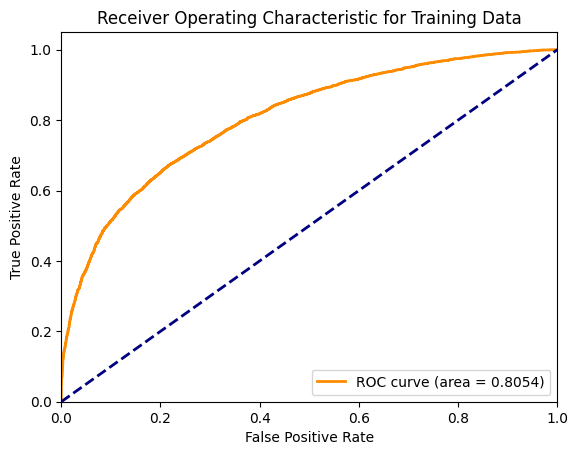

In [326]:
# Generate ROC curve for training data
fpr, tpr, thresholds = roc_curve(y_train.cat.codes, pprob)
roc_auc = roc_auc_score(y_train.cat.codes, pprob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

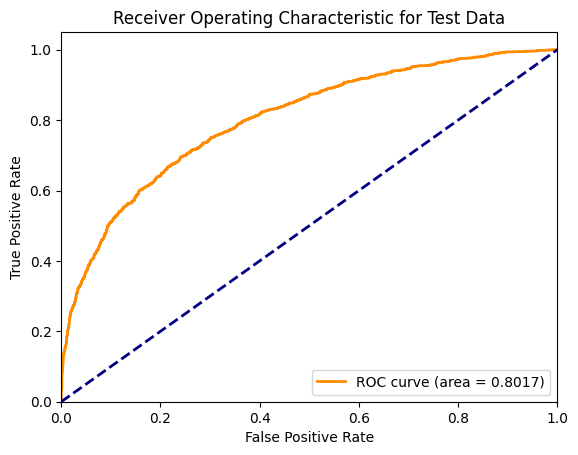

In [327]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, pprob_test)
roc_auc = roc_auc_score(y_test.cat.codes, pprob_test)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()

In [328]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, psuccess)
prec_train = precision_score(y_train, psuccess)
rec_train = recall_score(y_train, psuccess)
auc_train = roc_auc_score(y_train,pprob)

# print the scores

print("Accuracy (Train) : {:.4f}".format(acc_train))
print("Precision (Train): {:.4f}".format(prec_train))
print("Recall (Train)   : {:.4f}".format(rec_train))
print("AUC (Train)      : {:.4f}".format(auc_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test, psuccess_test)
prec_test = precision_score(y_test, psuccess_test)
rec_test = recall_score(y_test, psuccess_test)
auc_test = roc_auc_score(y_test, pprob_test)

# print the scores

print("Accuracy (Test) : {:.4f}".format(acc_test))
print("Precision (Test): {:.4f}".format(prec_test))
print("Recall (Test)   : {:.4f}".format(rec_test))
print("AUC (Test)      : {:.4f}".format(auc_test))
print("")


Accuracy (Train) : 0.8097
Precision (Train): 0.7016
Recall (Train)   : 0.3932
AUC (Train)      : 0.8054

Accuracy (Test) : 0.8057
Precision (Test): 0.7018
Recall (Test)   : 0.3840
AUC (Test)      : 0.8017



##Model 2: Reduced Logistic Regression with Stepwise Feature Selection

In [329]:
df.columns

Index(['ID', 'DemAffl', 'DemAge', 'DemCluster', 'DemClusterGroup', 'DemGender',
       'DemReg', 'DemTVReg', 'PromClass', 'PromSpend', 'PromTime', 'TargetBuy',
       'TargetAmt'],
      dtype='object')

In [330]:
#df columns: ['ID', 'DemAffl', 'DemAge', 'DemCluster', 'DemClusterGroup', 'DemGender', 'DemReg', 'DemTVReg', 'PromClass', 'PromSpend', 'PromTime', 'TargetBuy', 'TargetAmt']
#define categorical columns
cat_col = ['DemClusterGroup','DemGender','DemReg','DemTVReg','PromClass']

#split the data into training and testing sets
#X2 = df.drop(['ID', 'DemCluster','DemGender', 'DemReg', 'DemTVReg', 'PromTime', 'TargetBuy', 'TargetAmt'], axis=1)
X2= df[['DemAffl','DemAge','PromSpend', 'DemGender', 'PromClass']]
X2 = pd.get_dummies(X2, columns=['DemGender', 'PromClass'], drop_first=False)

y2 = df['TargetBuy']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

X2_train.info()
y2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15084 entries, 4476 to 16280
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DemAffl             15084 non-null  float64
 1   DemAge              15084 non-null  float64
 2   PromSpend           15084 non-null  float64
 3   DemGender_F         15084 non-null  uint8  
 4   DemGender_M         15084 non-null  uint8  
 5   DemGender_U         15084 non-null  uint8  
 6   PromClass_Gold      15084 non-null  uint8  
 7   PromClass_Platinum  15084 non-null  uint8  
 8   PromClass_Silver    15084 non-null  uint8  
 9   PromClass_Tin       15084 non-null  uint8  
dtypes: float64(3), uint8(7)
memory usage: 574.5 KB
<class 'pandas.core.series.Series'>
Int64Index: 15084 entries, 4476 to 16280
Series name: TargetBuy
Non-Null Count  Dtype   
--------------  -----   
15084 non-null  category
dtypes: category(1)
memory usage: 132.7 KB


In [331]:
#Fit reduced (stepwise) logistic regression model to examine the significance of the terms
X2 = X2_train
X2 = sm.add_constant(X2)
y2=y2_train

logit_step = sm.Logit(y2, X2).fit()

#Print summary
print(logit_step.summary())

Optimization terminated successfully.
         Current function value: 0.432737
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              TargetBuy   No. Observations:                15084
Model:                          Logit   Df Residuals:                    15075
Method:                           MLE   Df Model:                            8
Date:                Wed, 22 Nov 2023   Pseudo R-squ.:                  0.2241
Time:                        04:23:10   Log-Likelihood:                -6527.4
converged:                       True   LL-Null:                       -8412.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.7565   8.15e+05  -9.29e-07      1.000    -1.6e+06     1.6e+06
DemAf

In [332]:
# Generate predicted values for training set
pprob2 = logit_step.predict(X2)

# Create predicted category for success using 50% cutoff
psuccess2 = (pprob2 > 0.5).astype(int)

# Add new variables to the training data set
X2_train['p_success'] = psuccess2
X2_train['p_prob'] = pprob2
X2_train['y'] = y2_train

X2_train.info()


# Generate predicted values for test set

X2_test = sm.add_constant(X2_test)

pprob2_test = logit_step.predict(X2_test)

# Create predicted category for success using 50% cutoff
psuccess2_test = (pprob2_test > 0.5).astype(int)

# Add new variables to the response data set
X2_test['p_success'] = psuccess2_test
X2_test['p_prob'] = pprob2_test

X2_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15084 entries, 4476 to 16280
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   DemAffl             15084 non-null  float64 
 1   DemAge              15084 non-null  float64 
 2   PromSpend           15084 non-null  float64 
 3   DemGender_F         15084 non-null  uint8   
 4   DemGender_M         15084 non-null  uint8   
 5   DemGender_U         15084 non-null  uint8   
 6   PromClass_Gold      15084 non-null  uint8   
 7   PromClass_Platinum  15084 non-null  uint8   
 8   PromClass_Silver    15084 non-null  uint8   
 9   PromClass_Tin       15084 non-null  uint8   
 10  p_success           15084 non-null  int64   
 11  p_prob              15084 non-null  float64 
 12  y                   15084 non-null  category
dtypes: category(1), float64(4), int64(1), uint8(7)
memory usage: 825.0 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6465 entries,

In [333]:
# Generate confusion matrix for training set
conf_matrix = confusion_matrix(psuccess2, y2_train)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(psuccess2_test, y2_test)
print(conf_matrix)

[[10769  2256]
 [  607  1452]]
[[4590 1007]
 [ 263  605]]


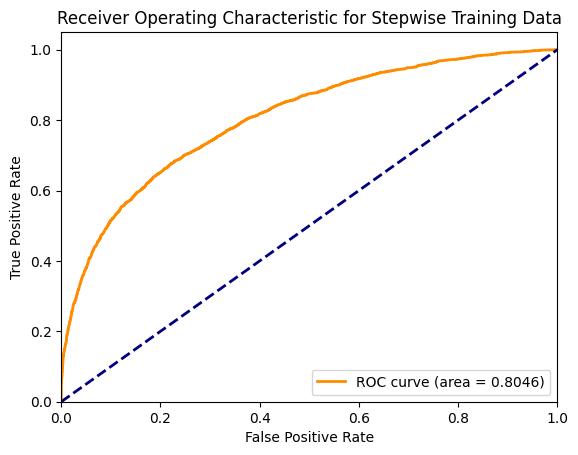

In [334]:
# Generate ROC curve for training data
fpr, tpr, thresholds = roc_curve(y2_train.cat.codes, pprob2)
roc_auc = roc_auc_score(y2_train.cat.codes, pprob2)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Stepwise Training Data')
plt.legend(loc='lower right')
plt.show()

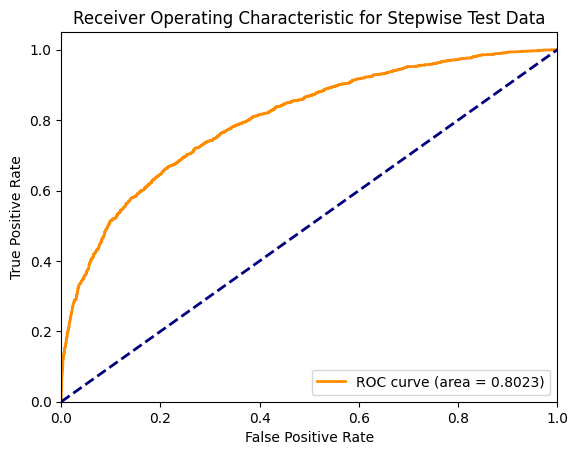

In [335]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y2_test.cat.codes, pprob2_test)
roc_auc = roc_auc_score(y2_test.cat.codes, pprob2_test)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Stepwise Test Data')
plt.legend(loc='lower right')
plt.show()

In [336]:
# calculate the accuracy, precision, and recall scores
acc_train2 = accuracy_score(y2_train, psuccess2)
prec_train2 = precision_score(y2_train, psuccess2)
rec_train2 = recall_score(y2_train, psuccess2)
auc_train2 = roc_auc_score(y2_train,pprob2)

# print the scores

print("Accuracy (Train) : {:.4f}".format(acc_train2))
print("Precision (Train): {:.4f}".format(prec_train2))
print("Recall (Train)  : {:.4f}".format(rec_train2))
print("AUC (Train)      : {:.4f}".format(auc_train2))
print("")

# calculate the accuracy, precision, and recall scores
acc_test2 = accuracy_score(y2_test, psuccess2_test)
prec_test2 = precision_score(y2_test, psuccess2_test)
rec_test2 = recall_score(y2_test, psuccess2_test)
auc_test2 = roc_auc_score(y2_test, pprob2_test)

# print the scores

print("Accuracy (Test) : {:.4f}".format(acc_test2))
print("Precision (Test): {:.4f}".format(prec_test2))
print("Recall (Test)  : {:.4f}".format(rec_test2))
print("AUC (Test)      : {:.4f}".format(auc_test2))
print("")


Accuracy (Train) : 0.8102
Precision (Train): 0.7052
Recall (Train)  : 0.3916
AUC (Train)      : 0.8046

Accuracy (Test) : 0.8036
Precision (Test): 0.6970
Recall (Test)  : 0.3753
AUC (Test)      : 0.8023



##Model 3,4,5,6: Reduced Logistic Model with L1, L2, and Elastic Net Regularization

In [337]:
#define categorical columns
cat_col = ['DemClusterGroup','DemGender','DemReg','DemTVReg','PromClass']

# split the data into training and testing sets
X3 = df.drop(['TargetBuy', 'ID', 'TargetAmt'], axis=1)
#X3=df[['DemAffl', 'DemAge', 'DemCluster', 'DemClusterGroup', 'DemGender', 'DemReg', 'DemTVReg', 'PromClass', 'PromSpend', 'PromTime']]
X3 = pd.get_dummies(X3, columns=cat_col, drop_first=False)

y3 = df['TargetBuy']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

X3_train.info()

y3_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15084 entries, 4476 to 16280
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DemAffl                15084 non-null  float64
 1   DemAge                 15084 non-null  float64
 2   DemCluster             15084 non-null  float64
 3   PromSpend              15084 non-null  float64
 4   PromTime               15084 non-null  float64
 5   DemClusterGroup_A      15084 non-null  uint8  
 6   DemClusterGroup_B      15084 non-null  uint8  
 7   DemClusterGroup_C      15084 non-null  uint8  
 8   DemClusterGroup_D      15084 non-null  uint8  
 9   DemClusterGroup_E      15084 non-null  uint8  
 10  DemClusterGroup_F      15084 non-null  uint8  
 11  DemClusterGroup_U      15084 non-null  uint8  
 12  DemGender_F            15084 non-null  uint8  
 13  DemGender_M            15084 non-null  uint8  
 14  DemGender_U            15084 non-null  uint8  
 15 

In [338]:
# Create an Instance of Logistic Regression for LASSO Selection  using c = 0.5 and c = 0.01

lr_l1_1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.5)
lr_l1_01 = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)

# fit the models to the training data
lr_l1_1.fit(X3_train, y3_train)
lr_l1_01.fit(X3_train, y3_train)

# Create an Instance of Logistic Regression for Ridge Regression (L2 regularization)
lr_l2 = LogisticRegression(penalty='l2', solver='liblinear')

# Create an instance of Logistic Regression for Elastic Net
lr_l12 = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga')

# fit the models to the training data
lr_l2.fit(X3_train, y3_train)
lr_l12.fit(X3_train, y3_train)

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

In [339]:
#print coefficients and absolute value of coefficients for all models
df_coefficients1 = rpt_model_variables(lr_l1_1)
df_coefficients01 = rpt_model_variables(lr_l1_01)
df_coefficients2 = rpt_model_variables(lr_l2)
df_coefficients12 = rpt_model_variables(lr_l12)

                  feature  coefficient  abs_coefficient
14            DemGender_U      -1.7477           1.7477
13            DemGender_M      -0.9241           0.9241
0                 DemAffl       0.2489           0.2489
26        DemTVReg_N East       0.2253           0.2253
35     PromClass_Platinum      -0.2021           0.2021
11      DemClusterGroup_U       0.1750           0.1750
29    DemTVReg_S & S East      -0.1188           0.1188
16           DemReg_North      -0.1016           0.1016
5       DemClusterGroup_A      -0.0718           0.0718
32  DemTVReg_Wales & West       0.0625           0.0625
1                  DemAge      -0.0532           0.0532
36       PromClass_Silver      -0.0457           0.0457
8       DemClusterGroup_D      -0.0426           0.0426
33     DemTVReg_Yorkshire      -0.0382           0.0382
23          DemTVReg_East       0.0359           0.0359
31             DemTVReg_U      -0.0338           0.0338
22    DemTVReg_C Scotland      -0.0237          

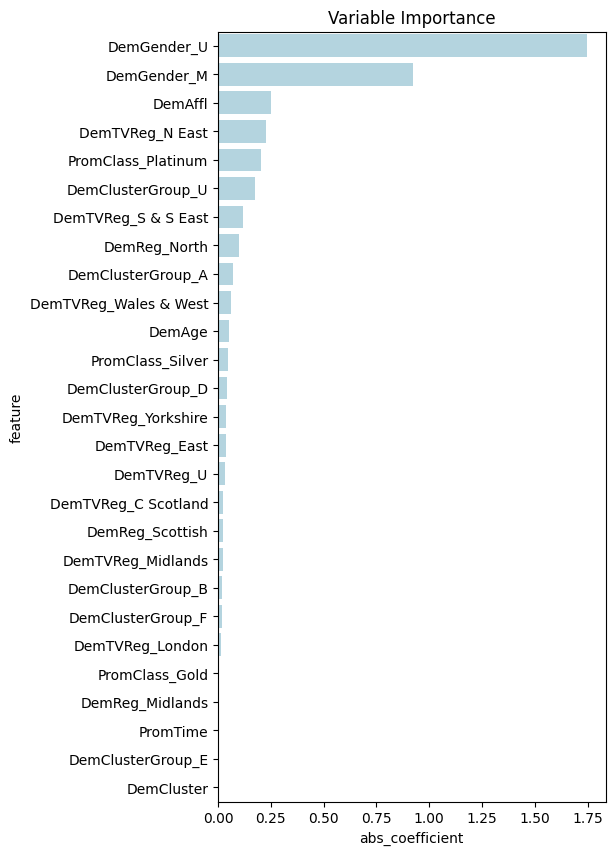

-- rejected --
 DemTVReg_S West
 DemReg_South West
 DemTVReg_N West
 DemTVReg_N Scot
 DemTVReg_Border
 DemReg_U
 DemReg_South East
 DemGender_F
 DemClusterGroup_C
 PromSpend
 PromClass_Tin


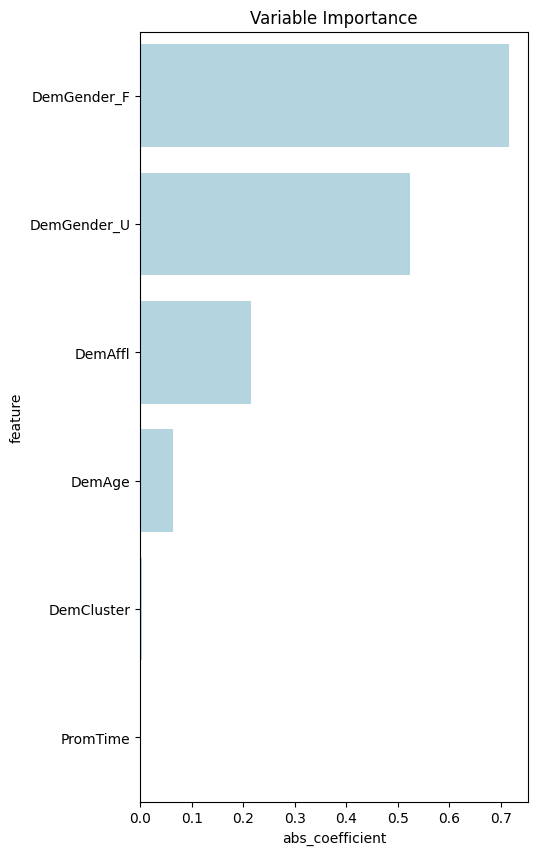

-- rejected --
 DemTVReg_London
 DemTVReg_Midlands
 DemTVReg_N East
 DemTVReg_N Scot
 DemTVReg_N West
 DemTVReg_S West
 DemTVReg_S & S East
 DemTVReg_C Scotland
 DemTVReg_U
 DemTVReg_Wales & West
 DemTVReg_Yorkshire
 PromClass_Gold
 PromClass_Platinum
 PromClass_Silver
 DemTVReg_East
 DemReg_South West
 DemTVReg_Border
 DemReg_U
 DemReg_South East
 DemReg_Scottish
 DemReg_North
 DemReg_Midlands
 DemGender_M
 DemClusterGroup_U
 DemClusterGroup_F
 DemClusterGroup_E
 DemClusterGroup_D
 DemClusterGroup_C
 DemClusterGroup_B
 DemClusterGroup_A
 PromSpend
 PromClass_Tin


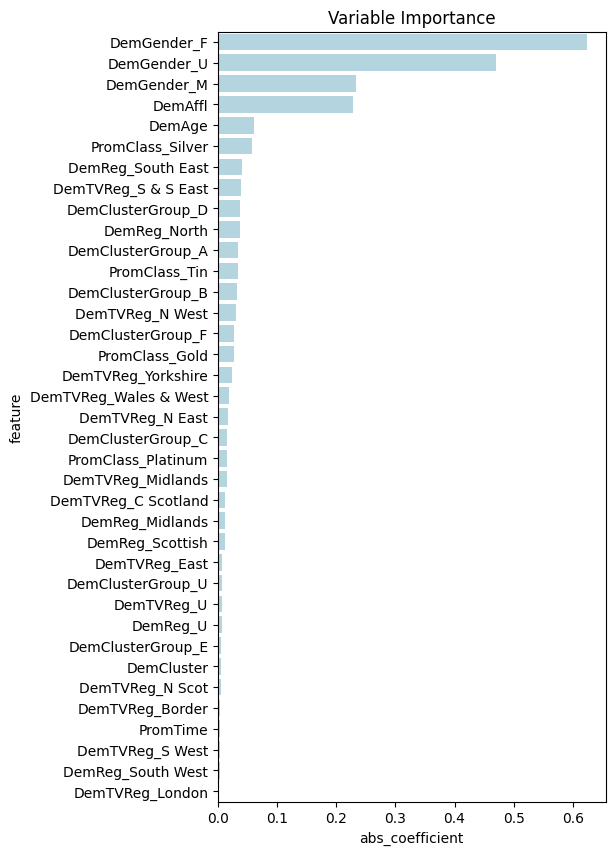

-- rejected --
 PromSpend


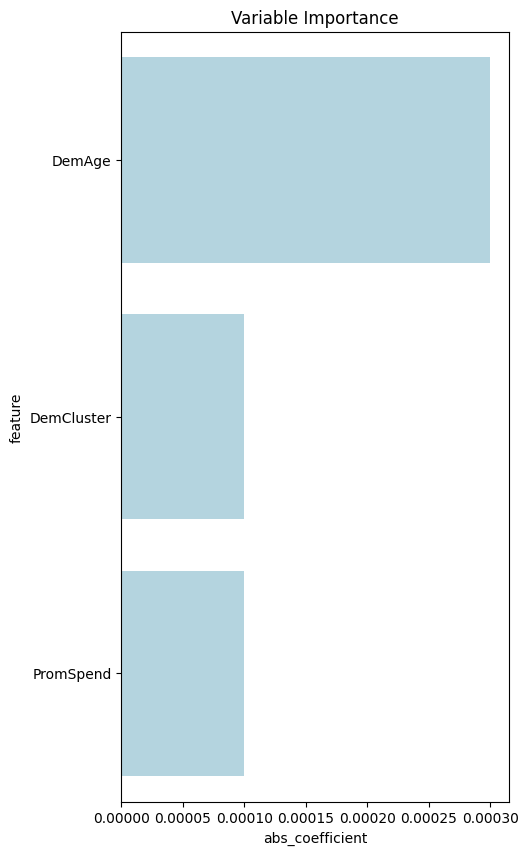

-- rejected --
 DemTVReg_S & S East
 DemTVReg_C Scotland
 DemTVReg_East
 DemTVReg_London
 DemTVReg_Midlands
 DemTVReg_N East
 DemTVReg_N Scot
 DemTVReg_N West
 DemAffl
 DemTVReg_Border
 DemTVReg_U
 DemTVReg_Wales & West
 DemTVReg_Yorkshire
 PromClass_Gold
 PromClass_Platinum
 PromClass_Silver
 DemTVReg_S West
 DemReg_South West
 DemReg_U
 DemClusterGroup_F
 PromTime
 DemClusterGroup_A
 DemClusterGroup_B
 DemClusterGroup_C
 DemClusterGroup_D
 DemClusterGroup_E
 DemClusterGroup_U
 DemReg_South East
 DemGender_F
 DemGender_M
 DemGender_U
 DemReg_Midlands
 DemReg_North
 DemReg_Scottish
 PromClass_Tin


In [340]:
#Plot Variable importances
plot_variable_imp(df_coefficients1) #L1, c=0.5
plot_variable_imp(df_coefficients01) #L1, c=0.01
plot_variable_imp(df_coefficients2) #L2
plot_variable_imp(df_coefficients12) #Elastic Net

In [341]:
# make predictions on the testing data
y_pred_train = lr_l1_1.predict(X3_train)
y_pred_test = lr_l1_1.predict(X3_test)
y_proba_train = lr_l1_1.predict_proba(X3_train)
y_proba_test = lr_l1_1.predict_proba(X3_test)

y_pred_train1 = lr_l1_01.predict(X3_train)
y_pred_test1 = lr_l1_01.predict(X3_test)
y_proba_train1 = lr_l1_01.predict_proba(X3_train)
y_proba_test1 = lr_l1_01.predict_proba(X3_test)

y_pred_train2 = lr_l2.predict(X3_train)
y_pred_test2 = lr_l2.predict(X3_test)
y_proba_train2 = lr_l2.predict_proba(X3_train)
y_proba_test2 = lr_l2.predict_proba(X3_test)

y_pred_train12 = lr_l12.predict(X3_train)
y_pred_test12 = lr_l12.predict(X3_test)
y_proba_train12 = lr_l12.predict_proba(X3_train)
y_proba_test12 = lr_l12.predict_proba(X3_test)

###Accuracy, Precision, Recall, AUC

In [342]:
# calculate the accuracy, precision, and recall scores for L1, c=0.5
acc3_train = accuracy_score(y3_train, y_pred_train)
prec3_train = precision_score(y3_train, y_pred_train)
rec3_train = recall_score(y3_train, y_pred_train)
auc3_train = roc_auc_score(y3_train, y_proba_train[:,1])

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc3_train))
print("Precision: {:.4f}".format(prec3_train))
print("Recall.  : {:.4f}".format(rec3_train))
print("AUC      : {:.4f}".format(auc3_train))
print("")

# calculate the accuracy, precision, and recall scores
acc3_test = accuracy_score(y3_test, y_pred_test)
prec3_test = precision_score(y3_test, y_pred_test)
rec3_test = recall_score(y3_test, y_pred_test)
auc3_test = roc_auc_score(y3_test, y_proba_test[:,1])

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc3_test))
print("Precision: {:.4f}".format(prec3_test))
print("Recall.  : {:.4f}".format(rec3_test))
print("AUC      : {:.4f}".format(auc3_test))

 -- train set -- 
Accuracy : 0.8097
Precision: 0.7013
Recall.  : 0.3932
AUC      : 0.8052

 -- test set -- 
Accuracy : 0.8051
Precision: 0.7028
Recall.  : 0.3784
AUC      : 0.8019


In [343]:
# calculate the accuracy, precision, and recall scores L1, c=0.01
acc3_train1 = accuracy_score(y3_train, y_pred_train1)
prec3_train1 = precision_score(y3_train, y_pred_train1)
rec3_train1 = recall_score(y3_train, y_pred_train1)
auc3_train1 = roc_auc_score(y3_train, y_proba_train1[:,1])

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc3_train1))
print("Precision: {:.4f}".format(prec3_train1))
print("Recall.  : {:.4f}".format(rec3_train1))
print("AUC      : {:.4f}".format(auc3_train1))
print("")

# calculate the accuracy, precision, and recall scores
acc3_test1 = accuracy_score(y3_test, y_pred_test1)
prec3_test1 = precision_score(y3_test, y_pred_test1)
rec3_test1 = recall_score(y3_test, y_pred_test1)
auc3_test1 = roc_auc_score(y3_test, y_proba_test1[:,1])

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc3_test1))
print("Precision: {:.4f}".format(prec3_test1))
print("Recall.  : {:.4f}".format(rec3_test1))
print("AUC      : {:.4f}".format(auc3_test1))

 -- train set -- 
Accuracy : 0.8111
Precision: 0.7101
Recall.  : 0.3910
AUC      : 0.7981

 -- test set -- 
Accuracy : 0.8065
Precision: 0.7026
Recall.  : 0.3883
AUC      : 0.7949


In [344]:
# calculate the accuracy, precision, and recall scores for L2
acc3_train2 = accuracy_score(y3_train, y_pred_train2)
prec3_train2 = precision_score(y3_train, y_pred_train2)
rec3_train2 = recall_score(y3_train, y_pred_train2)
auc3_train2 = roc_auc_score(y3_train, y_proba_train2[:,1])

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc3_train2))
print("Precision: {:.4f}".format(prec3_train2))
print("Recall.  : {:.4f}".format(rec3_train2))
print("AUC      : {:.4f}".format(auc3_train2))
print("")

# calculate the accuracy, precision, and recall scores
acc3_test2 = accuracy_score(y3_test, y_pred_test2)
prec3_test2 = precision_score(y3_test, y_pred_test2)
rec3_test2 = recall_score(y3_test, y_pred_test2)
auc3_test2 = roc_auc_score(y3_test, y_proba_test2[:,1])

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc3_test2))
print("Precision: {:.4f}".format(prec3_test2))
print("Recall.  : {:.4f}".format(rec3_test2))
print("AUC      : {:.4f}".format(auc3_test2))

 -- train set -- 
Accuracy : 0.8112
Precision: 0.7131
Recall.  : 0.3881
AUC      : 0.7990

 -- test set -- 
Accuracy : 0.8056
Precision: 0.7047
Recall.  : 0.3790
AUC      : 0.7952


In [345]:
# calculate the accuracy, precision, and recall scores for Elastic Net
acc3_train12 = accuracy_score(y3_train, y_pred_train12)
prec3_train12 = precision_score(y3_train, y_pred_train12)
rec3_train12 = recall_score(y3_train, y_pred_train12)
auc3_train12 = roc_auc_score(y3_train, y_proba_train12[:,1])

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc3_train12))
print("Precision: {:.4f}".format(prec3_train12))
print("Recall.  : {:.4f}".format(rec3_train12))
print("AUC      : {:.4f}".format(auc3_train12))
print("")

# calculate the accuracy, precision, and recall scores
acc3_test12 = accuracy_score(y3_test, y_pred_test12)
prec3_test12 = precision_score(y3_test, y_pred_test12)
rec3_test12 = recall_score(y3_test, y_pred_test12)
auc3_test12 = roc_auc_score(y3_test, y_proba_test12[:,1])

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc3_test12))
print("Precision: {:.4f}".format(prec3_test12))
print("Recall.  : {:.4f}".format(rec3_test12))
print("AUC      : {:.4f}".format(auc3_test12))

 -- train set -- 
Accuracy : 0.7542
Precision: 0.0000
Recall.  : 0.0000
AUC      : 0.5977

 -- test set -- 
Accuracy : 0.7507
Precision: 0.0000
Recall.  : 0.0000
AUC      : 0.6012


##Model 7: Decision Tree

In [346]:
#define categorical columns
cat_col = ['DemClusterGroup','DemGender','DemReg','DemTVReg','PromClass']

# split the data into training and testing sets
X4 = df.drop(['TargetBuy', 'ID', 'TargetAmt'], axis=1)
X4 = pd.get_dummies(X4, columns=cat_col, drop_first=False)

y4 = df['TargetBuy']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=42)

X4_train.info()

y4_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15084 entries, 4476 to 16280
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DemAffl                15084 non-null  float64
 1   DemAge                 15084 non-null  float64
 2   DemCluster             15084 non-null  float64
 3   PromSpend              15084 non-null  float64
 4   PromTime               15084 non-null  float64
 5   DemClusterGroup_A      15084 non-null  uint8  
 6   DemClusterGroup_B      15084 non-null  uint8  
 7   DemClusterGroup_C      15084 non-null  uint8  
 8   DemClusterGroup_D      15084 non-null  uint8  
 9   DemClusterGroup_E      15084 non-null  uint8  
 10  DemClusterGroup_F      15084 non-null  uint8  
 11  DemClusterGroup_U      15084 non-null  uint8  
 12  DemGender_F            15084 non-null  uint8  
 13  DemGender_M            15084 non-null  uint8  
 14  DemGender_U            15084 non-null  uint8  
 15 

In [347]:
# create an instance of a decision tree classifier using default values

dt = DecisionTreeClassifier(max_depth = 15, min_samples_leaf=10, ccp_alpha = 0.0005)

# fit the model to the training data
dt.fit(X4_train, y4_train)

DecisionTreeClassifier(ccp_alpha=0.0005, max_depth=15, min_samples_leaf=10)

In [348]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# visualize the decision tree
dot_data = export_graphviz(dt, filled=True, rounded=True, feature_names=X4.columns, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph.render("decision_tree_default")


'decision_tree_default.pdf'

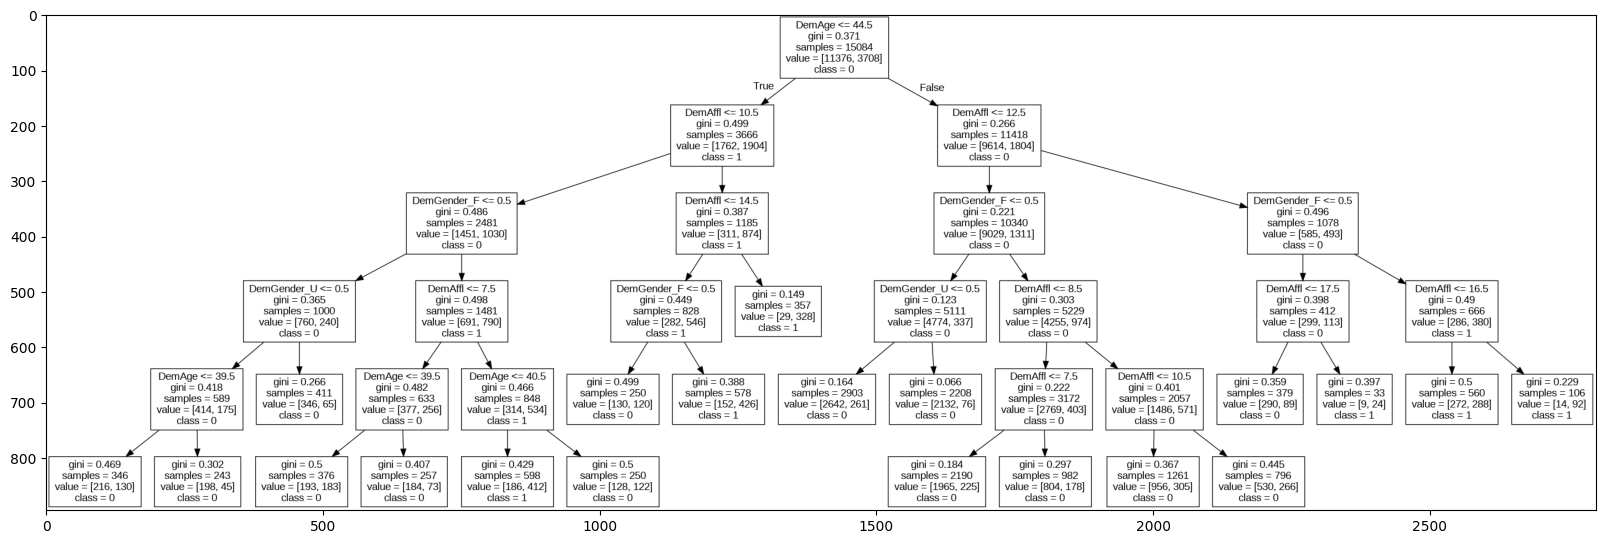

In [349]:
export_graphviz(dt,
                'tree.dot',
                class_names=['0','1'],
                feature_names = X4_train.columns)
! dot -Tpng tree.dot -o tree.png

import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 40))
plt.imshow(img)

In [350]:
# make predictions on the training and test data
y_pred_train4 = dt.predict(X4_train)
y_pred_test4 = dt.predict(X4_test)

y_prob_train4 = dt.predict_proba(X4_train)
y_prob_test4 = dt.predict_proba(X4_test)

In [351]:
# calculate the accuracy, precision, and recall scores for L2
acc_train4 = accuracy_score(y4_train, y_pred_train4)
prec_train4 = precision_score(y4_train, y_pred_train4)
rec_train4 = recall_score(y4_train, y_pred_train4)
auc_train4 = roc_auc_score(y4_train, y_prob_train4[:,1])

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train4))
print("Precision: {:.4f}".format(prec_train4))
print("Recall.  : {:.4f}".format(rec_train4))
print("AUC      : {:.4f}".format(auc_train4))
print("")

# calculate the accuracy, precision, and recall scores
acc_test4 = accuracy_score(y4_test, y_pred_test4)
prec_test4 = precision_score(y4_test, y_pred_test4)
rec_test4 = recall_score(y4_test, y_pred_test4)
auc_test4 = roc_auc_score(y4_test, y_prob_test4[:,1])

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test4))
print("Precision: {:.4f}".format(prec_test4))
print("Recall.  : {:.4f}".format(rec_test4))
print("AUC      : {:.4f}".format(auc_test4))

 -- train set -- 
Accuracy : 0.8144
Precision: 0.7034
Recall.  : 0.4234
AUC      : 0.8165

 -- test set -- 
Accuracy : 0.8074
Precision: 0.6921
Recall.  : 0.4100
AUC      : 0.8124


In [352]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train4, y4_train)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test4, y4_test)
print(conf_matrix)

[[10714  2138]
 [  662  1570]]
[[4559  951]
 [ 294  661]]


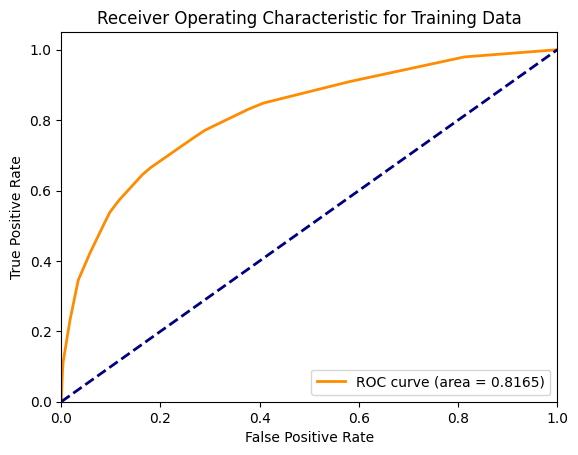

In [353]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y4_train.cat.codes, y_prob_train4[:,1])
roc_auc = roc_auc_score(y4_train.cat.codes, y_prob_train4[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

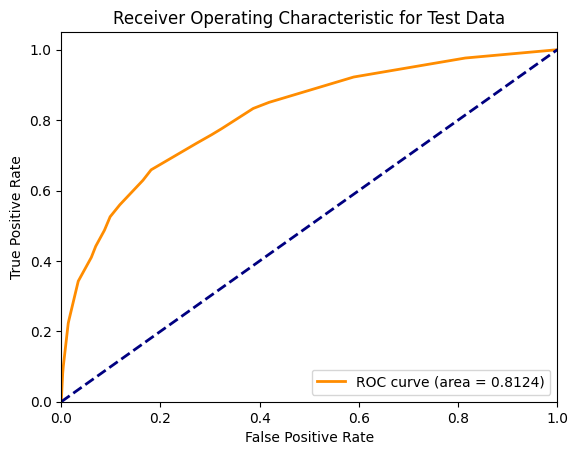

In [354]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y4_test.cat.codes, y_prob_test4[:,1])
roc_auc = roc_auc_score(y4_test.cat.codes, y_prob_test4[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()


    importance                feature
1     0.480703                 DemAge
0     0.353706                DemAffl
12    0.154821            DemGender_F
14    0.010771            DemGender_U
36    0.000000       PromClass_Silver
35    0.000000     PromClass_Platinum
22    0.000000    DemTVReg_C Scotland
23    0.000000          DemTVReg_East
24    0.000000        DemTVReg_London
25    0.000000      DemTVReg_Midlands
26    0.000000        DemTVReg_N East
27    0.000000        DemTVReg_N Scot
21    0.000000        DemTVReg_Border
29    0.000000    DemTVReg_S & S East
30    0.000000        DemTVReg_S West
31    0.000000             DemTVReg_U
32    0.000000  DemTVReg_Wales & West
33    0.000000     DemTVReg_Yorkshire
34    0.000000         PromClass_Gold
28    0.000000        DemTVReg_N West
19    0.000000      DemReg_South West
20    0.000000               DemReg_U
8     0.000000      DemClusterGroup_D
2     0.000000             DemCluster
3     0.000000              PromSpend
4     0.0000

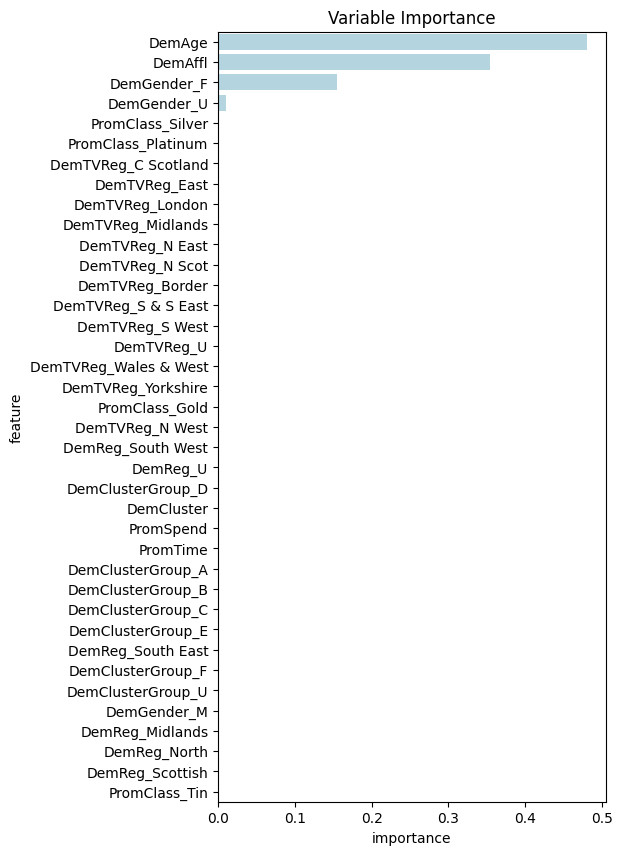

In [355]:
#calculate feature importance
tree_imp = dt.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df1 = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df1['feature']=X4.columns

#sort data so features with largest importance values are at the top
df2 = df1.sort_values(by=['importance'], ascending=False)

print(df2)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2,
            y=df2['feature'],
            x=df2['importance'], color="lightblue")

plt.show()

##Model 8: Random Forest Model (Exploration, code from Kaggle)

In [356]:
#define categorical columns
cat_col = ['DemClusterGroup','DemGender','DemReg','DemTVReg','PromClass']

# split the data into training and testing sets
X5 = df.drop(['TargetBuy', 'ID', 'TargetAmt'], axis=1)
X5 = pd.get_dummies(X5, columns=cat_col, drop_first=False)

y5 = df['TargetBuy']
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.3, random_state=40)

X5_train.info()

y5_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15084 entries, 18616 to 11944
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DemAffl                15084 non-null  float64
 1   DemAge                 15084 non-null  float64
 2   DemCluster             15084 non-null  float64
 3   PromSpend              15084 non-null  float64
 4   PromTime               15084 non-null  float64
 5   DemClusterGroup_A      15084 non-null  uint8  
 6   DemClusterGroup_B      15084 non-null  uint8  
 7   DemClusterGroup_C      15084 non-null  uint8  
 8   DemClusterGroup_D      15084 non-null  uint8  
 9   DemClusterGroup_E      15084 non-null  uint8  
 10  DemClusterGroup_F      15084 non-null  uint8  
 11  DemClusterGroup_U      15084 non-null  uint8  
 12  DemGender_F            15084 non-null  uint8  
 13  DemGender_M            15084 non-null  uint8  
 14  DemGender_U            15084 non-null  uint8  
 15

In [357]:
# instantiate the classifier, take from 25 different trees (note that accuracy stays the same at n_estimators=100)
rfc = RandomForestClassifier(n_estimators=25, random_state=0)
# fit the model
rfc.fit(X5_train, y5_train)

RandomForestClassifier(n_estimators=25, random_state=0)

In [358]:
# make predictions on the training and test data
y_pred_train5 = dt.predict(X5_train)
y_pred_test5 = dt.predict(X5_test)

y_prob_train5 = dt.predict_proba(X5_train)
y_prob_test5 = dt.predict_proba(X5_test)

In [359]:
# calculate the accuracy, precision, and recall scores for L2
acc_train5 = accuracy_score(y5_train, y_pred_train5)
prec_train5 = precision_score(y5_train, y_pred_train5)
rec_train5 = recall_score(y5_train, y_pred_train5)
auc_train5 = roc_auc_score(y5_train, y_prob_train5[:,1])

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train5))
print("Precision: {:.4f}".format(prec_train5))
print("Recall.  : {:.4f}".format(rec_train5))
print("AUC      : {:.4f}".format(auc_train5))
print("")

# calculate the accuracy, precision, and recall scores
acc_test5 = accuracy_score(y5_test, y_pred_test5)
prec_test5 = precision_score(y5_test, y_pred_test5)
rec_test5 = recall_score(y5_test, y_pred_test5)
auc_test5 = roc_auc_score(y5_test, y_prob_test5[:,1])

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test5))
print("Precision: {:.4f}".format(prec_test5))
print("Recall.  : {:.4f}".format(rec_test5))
print("AUC      : {:.4f}".format(auc_test5))

 -- train set -- 
Accuracy : 0.8107
Precision: 0.6935
Recall.  : 0.4189
AUC      : 0.8128

 -- test set -- 
Accuracy : 0.8159
Precision: 0.7158
Recall.  : 0.4203
AUC      : 0.8212


In [360]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train5, y5_train)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test5, y5_test)
print(conf_matrix)

[[10668  2165]
 [  690  1561]]
[[4605  924]
 [ 266  670]]


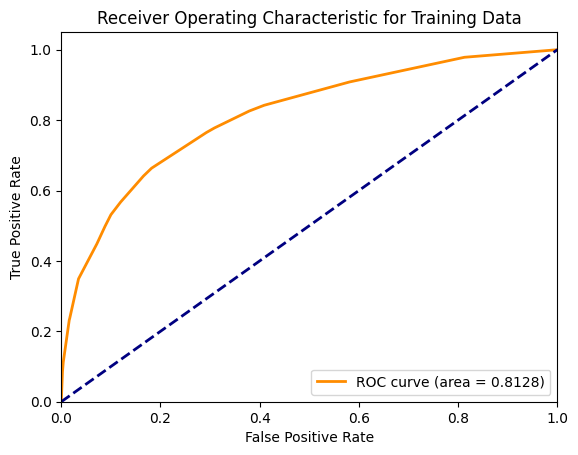

In [361]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y5_train.cat.codes, y_prob_train5[:,1])
roc_auc = roc_auc_score(y5_train.cat.codes, y_prob_train5[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

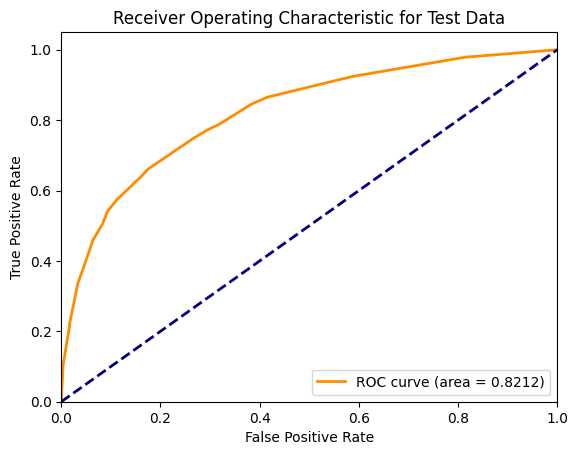

In [362]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y5_test.cat.codes, y_prob_test5[:,1])
roc_auc = roc_auc_score(y5_test.cat.codes, y_prob_test5[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()


    importance                feature
1     0.248306                 DemAge
0     0.184271                DemAffl
2     0.111498             DemCluster
4     0.104321               PromTime
3     0.091299              PromSpend
12    0.032265            DemGender_F
14    0.021332            DemGender_U
7     0.011984      DemClusterGroup_C
8     0.011889      DemClusterGroup_D
36    0.010548       PromClass_Silver
9     0.009971      DemClusterGroup_E
24    0.009750        DemTVReg_London
25    0.009625      DemTVReg_Midlands
13    0.009490            DemGender_M
6     0.009079      DemClusterGroup_B
10    0.008951      DemClusterGroup_F
18    0.008907      DemReg_South East
15    0.008583        DemReg_Midlands
29    0.007990    DemTVReg_S & S East
34    0.007845         PromClass_Gold
23    0.007780          DemTVReg_East
37    0.007741          PromClass_Tin
16    0.007454           DemReg_North
28    0.007443        DemTVReg_N West
32    0.007435  DemTVReg_Wales & West
33    0.0056

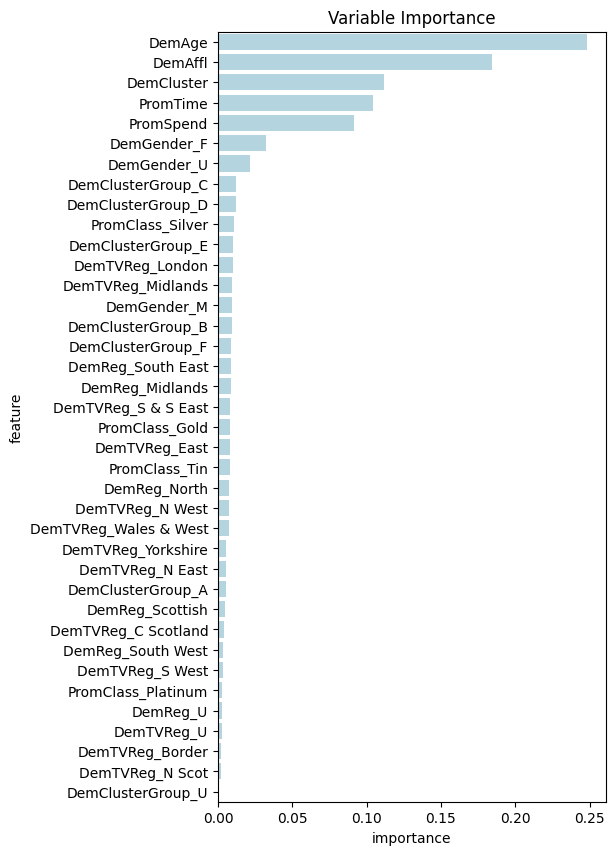

In [363]:
#calculate feature importance
forest_imp = rfc.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df3 = pd.DataFrame(data = forest_imp,
                  columns = column_values)
df3['feature']=X5.columns

#sort data so features with largest importance values are at the top
df4 = df3.sort_values(by=['importance'], ascending=False)

print(df4)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df4,
            y=df4['feature'],
            x=df4['importance'], color="lightblue")

plt.show()

#Making Prediction on New Organics using Classification Tree Models

In [364]:
#Prep dfnew to have the same columns as X3
#define categorical columns
cat_col = ['DemClusterGroup','DemGender','DemReg','DemTVReg','PromClass']

#define new data set df_new dropping ID and with the dummie variables
df_new = dfnew.drop(['ID'], axis=1)
df_new = pd.get_dummies(df_new, columns=cat_col, drop_first=False)

#create new columns for the 'unknowns' created when dealing with nulls in origional df and 'DemTVReg_Border' which appears in origional df but not dfnew
df_new['DemReg_U'] = 0
df_new['DemTVReg_U'] = df_new['DemTVReg_Ulster']
df_new = df_new.drop(['DemTVReg_Ulster'], axis = 1)
df_new['DemClusterGroup_U'] = 0
df_new['DemTVReg_Border'] = 0

#Get the columns in the right order
df_new = df_new[['DemAffl', 'DemAge', 'DemCluster', 'PromSpend', 'PromTime', 'DemClusterGroup_A', 'DemClusterGroup_B', 'DemClusterGroup_C', 'DemClusterGroup_D', 'DemClusterGroup_E', 'DemClusterGroup_F', 'DemClusterGroup_U', 'DemGender_F', 'DemGender_M', 'DemGender_U', 'DemReg_Midlands', 'DemReg_North', 'DemReg_Scottish', 'DemReg_South East', 'DemReg_South West', 'DemReg_U', 'DemTVReg_Border', 'DemTVReg_C Scotland', 'DemTVReg_East', 'DemTVReg_London', 'DemTVReg_Midlands', 'DemTVReg_N East', 'DemTVReg_N Scot', 'DemTVReg_N West', 'DemTVReg_S & S East', 'DemTVReg_S West', 'DemTVReg_U', 'DemTVReg_Wales & West', 'DemTVReg_Yorkshire', 'PromClass_Gold', 'PromClass_Platinum', 'PromClass_Silver', 'PromClass_Tin']]


In [365]:
# make predictions on the training and test data from the decision tree
Scored_class = dt.predict(df_new)
Scored_probs = dt.predict_proba(df_new)

df_new['pred_TargetBuy'] = Scored_class
df_new['prod_prob_TargetBuy']=Scored_probs[:,1]

print(df_new)

     DemAffl  DemAge  DemCluster  PromSpend  PromTime  DemClusterGroup_A  \
0          6      46          27       0.01         8                  0   
1         10      39          12       0.01         5                  0   
2          7      75          12    4000.00         7                  0   
3          7      72          12    1250.00        23                  0   
4          7      43          53       0.01         5                  0   
..       ...     ...         ...        ...       ...                ...   
145        3      59          12   12000.00         4                  0   
146        8      69          16   14400.00         8                  0   
147        7      27          52       0.01         4                  0   
148       10      63          14    3000.00         7                  0   
149       18      41          35       0.01         5                  0   

     DemClusterGroup_B  DemClusterGroup_C  DemClusterGroup_D  \
0                    0 

In [366]:
#check value counts for pred_TargetBuy
df_new['pred_TargetBuy'].value_counts()

0    131
1     19
Name: pred_TargetBuy, dtype: int64

In [367]:
#reset df_new
df_new = df_new[['DemAffl', 'DemAge', 'DemCluster', 'PromSpend', 'PromTime', 'DemClusterGroup_A', 'DemClusterGroup_B', 'DemClusterGroup_C', 'DemClusterGroup_D', 'DemClusterGroup_E', 'DemClusterGroup_F', 'DemClusterGroup_U', 'DemGender_F', 'DemGender_M', 'DemGender_U', 'DemReg_Midlands', 'DemReg_North', 'DemReg_Scottish', 'DemReg_South East', 'DemReg_South West', 'DemReg_U', 'DemTVReg_Border', 'DemTVReg_C Scotland', 'DemTVReg_East', 'DemTVReg_London', 'DemTVReg_Midlands', 'DemTVReg_N East', 'DemTVReg_N Scot', 'DemTVReg_N West', 'DemTVReg_S & S East', 'DemTVReg_S West', 'DemTVReg_U', 'DemTVReg_Wales & West', 'DemTVReg_Yorkshire', 'PromClass_Gold', 'PromClass_Platinum', 'PromClass_Silver', 'PromClass_Tin']]


In [368]:
# make predictions on the training and test data from the random forest model tree
Scored_class = rfc.predict(df_new)
Scored_probs = rfc.predict_proba(df_new)

df_new['pred_TargetBuy'] = Scored_class
df_new['prod_prob_TargetBuy']=Scored_probs[:,1]

print(df_new)

     DemAffl  DemAge  DemCluster  PromSpend  PromTime  DemClusterGroup_A  \
0          6      46          27       0.01         8                  0   
1         10      39          12       0.01         5                  0   
2          7      75          12    4000.00         7                  0   
3          7      72          12    1250.00        23                  0   
4          7      43          53       0.01         5                  0   
..       ...     ...         ...        ...       ...                ...   
145        3      59          12   12000.00         4                  0   
146        8      69          16   14400.00         8                  0   
147        7      27          52       0.01         4                  0   
148       10      63          14    3000.00         7                  0   
149       18      41          35       0.01         5                  0   

     DemClusterGroup_B  DemClusterGroup_C  DemClusterGroup_D  \
0                    0 

In [369]:
#check value counts for pred_TargetBuy
df_new['pred_TargetBuy'].value_counts()

0    118
1     32
Name: pred_TargetBuy, dtype: int64

In [374]:
#see all positive predicted entries
pospred_df = df_new[df_new['pred_TargetBuy'] == 1]
pospred_df.head(32)

,DemAffl,DemAge,DemCluster,PromSpend,PromTime,DemClusterGroup_A,DemClusterGroup_B,DemClusterGroup_C,DemClusterGroup_D,DemClusterGroup_E,...,DemTVReg_S West,DemTVReg_U,DemTVReg_Wales & West,DemTVReg_Yorkshire,PromClass_Gold,PromClass_Platinum,PromClass_Silver,PromClass_Tin,pred_TargetBuy,prod_prob_TargetBuy
1,10,39,12,0.01,5,0,1,0,0,0,...,0,1,0,0,0,0,0,1,1,0.56
12,15,35,19,1630.00,5,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,1.00
18,10,72,45,12000.00,8,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0.68
21,11,39,40,2800.00,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0.84
29,13,41,12,0.01,7,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0.84
30,16,34,28,3000.00,3,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0.96
31,6,40,32,1500.00,7,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0.80
32,9,35,53,0.01,4,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.80
48,3,38,53,50.00,9,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0.76
56,11,27,19,0.01,7,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0.72


#Create Scored Customer CSV

In [376]:
scored_customers = pd.DataFrame()

In [378]:
scored_customers['ID'] = dfnew['ID']
scored_customers['pred_TargetBuy']=df_new['pred_TargetBuy']
scored_customers['prob_TargetBuy']=df_new['prod_prob_TargetBuy']
scored_customers

,ID,pred_TargetBuy,prob_TargetBuy
0,1,0,0.00
1,2,1,0.56
2,3,0,0.08
3,4,0,0.08
4,5,0,0.04
...,...,...,...
145,146,0,0.28
146,147,0,0.24
147,158,1,0.84
148,149,0,0.04


In [381]:
scored_customers.to_csv('Scored_Customers_KaitlynVickers.csv', index=False)
print('success!')

success!
